# Visual comparisons

This notebook is a simple visualization of the differences between two networks by combining tools available in this repository.

To execute this notebook, you can use the pypsa-earth environment

### 1. Initial setup

General imports

In [1]:
import pypsa
import pandas as pd
import geopandas as gpd
from pypsa.clustering.spatial import get_clustering_from_busmap
import numpy as np

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



#### Get GID from json

In [41]:
gadm_usa_json_path = "/Users/fabriziofinozzi/Downloads/gadm41_USA_1.json"
gadm_gdp_usa = gpd.read_file(gadm_usa_json_path)
gadm_gdp_usa_state = gadm_gdp_usa[["GID_1", "NAME_1"]]
gadm_gdp_usa_state

,GID_1,NAME_1
0,USA.1_1,Alabama
1,USA.2_1,Alaska
2,USA.3_1,Arizona
3,USA.4_1,Arkansas
4,USA.5_1,California
5,USA.6_1,Colorado
6,USA.7_1,Connecticut
7,USA.8_1,Delaware
8,USA.9_1,DistrictofColumbia
9,USA.10_1,Florida


#### Specify what networks to compare

In [1]:
# use_drive enables to download default data from gdrive
# When use_drive is true and the path of the file is not found,
# but it matches a value from dictionary file_ids,
# then the file is downloaded from gdrive
use_gdrive = True

path_network_1 = "workflow/pypsa-earth/networks/US_2021/elec_s.nc"
# path_network_2 = "elec.nc"
gadm_shape = "workflow/pypsa-earth/resources/US_2021/shapes/gadm_shapes.geojson"

comparison_methodology = {
    "method": "shape",
    "options": {"path": gadm_shape},
}  # method option among: ["country_shape", "gadm_shape", ...]
# TODO: expand to include network_1 and network_2; example: create voronoi polygons and compare them or alike,
# or "find_closest" to compare the closest nodes

# global crs parameters
GEO_CRS = "EPSG:4326"
METRIC_CRS = "EPSG:3857"

### 2. Cluster network

In [3]:
# Load networks
n1_raw = pypsa.Network(path_network_1)  # first network
# n2 = pypsa.Network(path_network_2)  # second network

n1 = n1_raw.copy()
n1.lines.type = n1_raw.lines.type.iloc[0]


# Utility function for dataframe to geodataframe conversion
def buses_to_geodf(df_buses, INPUT_CRS=GEO_CRS, OUTPUT_CRS=METRIC_CRS):
    """Function to transform a buses dataframe into a geodataframe with the correct crs."""
    return gpd.GeoDataFrame(
        df_buses,
        geometry=gpd.points_from_xy(df_buses.x, df_buses.y),
        crs=INPUT_CRS,
    ).to_crs(OUTPUT_CRS)

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/li

### Create mapping of the networks for comparison purposes

##### Utility functions for mapping

In [4]:
gdf = gpd.read_file(gadm_shape)
len(gdf["GADM_ID"].unique().tolist())

51

In [5]:
def shape_mapping(n, options):
    """Create mapping by shape"""
    gdf = gpd.read_file(options["path"])

    # create GADM_ID and country if missing (country_shapes.geojson)
    if "GADM_ID" not in gdf.columns:
        gdf["GADM_ID"] = gdf["name"]
    if "country" not in gdf.columns:
        gdf["country"] = gdf["name"]

    gdf.set_index("GADM_ID", inplace=True)
    df_mapped = (
        n.buses.groupby("country")
        .apply(
            lambda x: gpd.sjoin_nearest(
                buses_to_geodf(x),
                gdf[gdf.country == x.name].to_crs(METRIC_CRS),
                how="inner",
            )
        )
        .droplevel(0, axis=0)
    )
    return (df_mapped["index_right"] + " " + df_mapped.carrier).rename("mapping")


def create_bus_mapping(n, method):
    """Function to create the bus mapping of network n according to a given methodology"""
    match method["method"]:
        case "shape":
            return shape_mapping(n, method["options"])
        case _:
            raise NotImplementedError(f"Method {method['method']} not implemented")

In [6]:
aggregation_strategies = {
    "generators": {  # use "min" for more conservative assumptions
        "p_nom": "sum",
        "p_nom_max": "sum",
        "p_nom_min": "sum",
        "p_min_pu": "mean",
        "marginal_cost": "mean",
        "committable": "any",
        "ramp_limit_up": "max",
        "ramp_limit_down": "max",
        "efficiency": "mean",
    }
}


def get_aggregation_strategies(aggregation_strategies):
    """
    Default aggregation strategies that cannot be defined in .yaml format must
    be specified within the function, otherwise (when defaults are passed in
    the function's definition) they get lost when custom values are specified
    in the config.
    """

    # to handle the new version of PyPSA.
    try:
        from pypsa.clustering.spatial import _make_consense
    except Exception:
        # TODO: remove after new release and update minimum pypsa version
        from pypsa.clustering.spatial import _make_consense

    bus_strategies = dict(country=_make_consense("Bus", "country"))
    bus_strategies.update(aggregation_strategies.get("buses", {}))

    generator_strategies = {"build_year": lambda x: 0, "lifetime": lambda x: np.inf}
    generator_strategies.update(aggregation_strategies.get("generators", {}))

    return bus_strategies, generator_strategies


# Bus aggregation strategies


def create_clustering(n, busmap, aggregation_strategies=aggregation_strategies):
    # get aggregation strategies
    bus_strategies, generator_strategies = get_aggregation_strategies(
        aggregation_strategies
    )

    # get clustering
    clustering = get_clustering_from_busmap(
        n,
        busmap,
        bus_strategies=bus_strategies,
        aggregate_generators_weighted=True,
        aggregate_generators_carriers=None,
        aggregate_one_ports=["Load", "StorageUnit"],
        line_length_factor=1.0,
        generator_strategies=generator_strategies,
        scale_link_capital_costs=False,
    )
    return clustering.network, busmap

In [7]:
def create_clustered_network(n, method):
    return create_clustering(n, create_bus_mapping(n, method))

In [8]:
df_bus = create_bus_mapping(n1, comparison_methodology)
df_bus_modified = create_bus_mapping(n1, comparison_methodology)
df_bus_modified = df_bus_modified[~df_bus_modified.index.duplicated()]

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_7561/1119178682.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



KeyError: 'index_right'

#### Execute the mapping

In [26]:
n1_mapped, n1_mapped_busmap = create_clustering(n1, df_bus_modified)
# n1_mapped, n1_mapped_busmap = create_clustered_network(n1, comparison_methodology)
# n2_mapped, n2_mapped_busmap = create_clustered_network(n2, comparison_methodology)

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

### 3. Execute the comparison

#### General statistics by networks

In [50]:
n1_mapped_buses = n1_mapped.buses
n1_mapped_buses["bus_name"] = n1_mapped_buses.index.str[:-2]
n1_mapped_buses

,v_nom,country,carrier,x,y,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network,generator,bus_name
Bus,,,,,,,,,,,,,,
US.10_1 AC,380.0,US,AC,-82.832394,28.998241,,,1.0,0.0,inf,Slack,0,US.10_1 AC CCGT,US.10_1
US.11_1 AC,380.0,US,AC,-83.523182,32.755900,,,1.0,0.0,inf,PQ,0,NaN,US.11_1
US.12_1 AC,380.0,US,AC,-151.791380,23.474580,,,1.0,0.0,inf,PQ,0,NaN,US.12_1
US.13_1 AC,380.0,US,AC,-113.872269,43.809350,,,1.0,0.0,inf,PQ,0,NaN,US.13_1
US.14_1 AC,380.0,US,AC,-89.131639,40.152395,,,1.0,0.0,inf,PQ,0,NaN,US.14_1
US.15_1 AC,380.0,US,AC,-86.286628,39.922350,,,1.0,0.0,inf,PQ,0,NaN,US.15_1
US.16_1 AC,380.0,US,AC,-93.666689,42.054737,,,1.0,0.0,inf,PQ,0,NaN,US.16_1
US.17_1 AC,380.0,US,AC,-97.736390,38.391815,,,1.0,0.0,inf,PQ,0,NaN,US.17_1
US.18_1 AC,380.0,US,AC,-85.439917,37.530086,,,1.0,0.0,inf,PQ,0,NaN,US.18_1


In [51]:
n1_mapped_buses = n1_mapped.buses
n1_mapped_buses["bus_name"] = n1_mapped_buses.index.str[:-2]
n1_mapped_buses_with_state = n1_mapped_buses.merge(
    gadm_gdp_usa_state, left_on="bus_name", right_on="GID_1"
)
n1_mapped_buses_with_state

,v_nom,country,carrier,x,y,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network,generator,bus_name,GID_1,NAME_1


In [27]:
n1_mapped.buses

,v_nom,country,carrier,x,y,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network,generator
Bus,,,,,,,,,,,,,
US.10_1 AC,380.0,US,AC,-82.832394,28.998241,,,1.0,0.0,inf,Slack,0,US.10_1 AC CCGT
US.11_1 AC,380.0,US,AC,-83.523182,32.755900,,,1.0,0.0,inf,PQ,0,NaN
US.12_1 AC,380.0,US,AC,-151.791380,23.474580,,,1.0,0.0,inf,PQ,0,NaN
US.13_1 AC,380.0,US,AC,-113.872269,43.809350,,,1.0,0.0,inf,PQ,0,NaN
US.14_1 AC,380.0,US,AC,-89.131639,40.152395,,,1.0,0.0,inf,PQ,0,NaN
US.15_1 AC,380.0,US,AC,-86.286628,39.922350,,,1.0,0.0,inf,PQ,0,NaN
US.16_1 AC,380.0,US,AC,-93.666689,42.054737,,,1.0,0.0,inf,PQ,0,NaN
US.17_1 AC,380.0,US,AC,-97.736390,38.391815,,,1.0,0.0,inf,PQ,0,NaN
US.18_1 AC,380.0,US,AC,-85.439917,37.530086,,,1.0,0.0,inf,PQ,0,NaN


In [28]:
s1 = n1_mapped.statistics()
s1

Capacity Factor  Capital Expenditure  \
            carrier                                                      
Generator   Biomass                           NaN                  0.0   
            Coal                              NaN                  0.0   
            Combined-Cycle Gas                NaN                  0.0   
            Csp                               NaN                  0.0   
            Geothermal                        NaN                  0.0   
            Nuclear                           NaN                  0.0   
            Offshore Wind (AC)                NaN                  0.0   
            Offshore Wind (DC)                NaN                  0.0   
            Oil                               NaN                  0.0   
            Onshore Wind                      NaN                  0.0   
            Open-Cycle Gas                    NaN                  0.0   
            Solar                             NaN                  0.0   
Line        AC                                NaN                  0.0   
Link        B2B                               NaN                  0.0   
            DC                                NaN                  0.0   
Load        -                                 NaN                  NaN   
StorageUnit Pumped Hydro Storage              NaN                  0.0   
            Reservoir & Dam                   NaN                  0.0   

                                  Curtailment  Dispatch  Installed Capacity  \
            carrier                                                           
Generator   Biomass                       0.0       0.0         6798.400000   
            Coal                          0.0       0.0       205445.800000   
            Combined-Cycle Gas            0.0       0.0       320680.700000   
            Csp                           0.0       0.0            0.000000   
            Geothermal                    0.0       0.0         3965.200000   
            Nuclear                       0.0       0.0        99435.000000   
            Offshore Wind (AC)            0.0       0.0            0.000000   
            Offshore Wind (DC)            0.0       0.0            0.000000   
            Oil                           0.0       0.0        35416.200000   
            Onshore Wind                  0.0       0.0       141739.300000   
            Open-Cycle Gas                0.0       0.0       245554.400000   
            Solar                         0.0       0.0        73112.400000   
Line        AC                            NaN       NaN       991489.600072   
Link        B2B                           NaN       NaN         4000.000000   
            DC                            NaN       NaN        40237.500000   
Load        -                             NaN       0.0                 NaN   
StorageUnit Pumped Hydro Storage          0.0       0.0        21989.300000   
            Reservoir & Dam               0.0       0.0        69385.600000   

                                  Market Value  Operational Expenditure  \
            carrier                                                       
Generator   Biomass                        NaN                      0.0   
            Coal                           NaN                      0.0   
            Combined-Cycle Gas             NaN                      0.0   
            Csp                            NaN                      0.0   
            Geothermal                     NaN                      0.0   
            Nuclear                        NaN                      0.0   
            Offshore Wind (AC)             NaN                      0.0   
            Offshore Wind (DC)             NaN                      0.0   
            Oil                            NaN                      0.0   
            Onshore Wind                   NaN                      0.0   
            Open-Cycle Gas                 NaN                      0.0 

In [ ]:
# s2 = n2_mapped.statistics()
# s2

Calculate percentage difference [\%]

In [ ]:
# delta_mapped = s2 - s1
# delta_mapped_pc = delta_mapped / s1 * 100
# delta_mapped_pc

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x37759cb20>,
 <matplotlib.collections.LineCollection at 0x3e0ab7a90>)

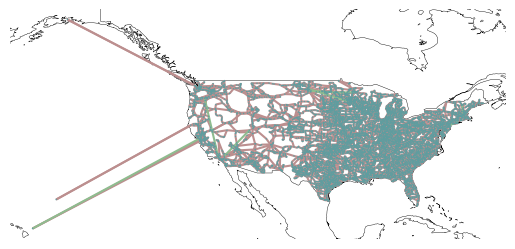

In [29]:
n1.plot()

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x3cf29f6d0>,
 <matplotlib.collections.LineCollection at 0x3cf516e90>)

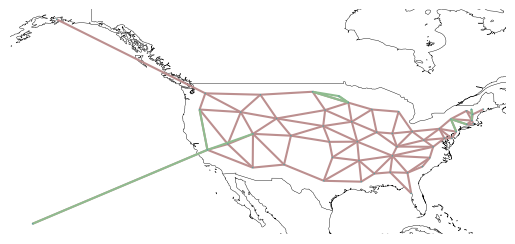

In [30]:
n1_mapped.plot()

In [86]:
n1_mapped.export_to_netcdf(
    "/Users/fabriziofinozzi/Desktop/OpenEnergyTransition/repo/geothermal-modelling/analysis/data/usa_mapped.nc"
)

INFO:pypsa.io:Exported network usa_mapped.nc has generators, links, buses, carriers, storage_units, loads, lines


<xarray.Dataset>
Dimensions:                               (snapshots: 8760,
                                           investment_periods: 0,
                                           generators_i: 473,
                                           generators_t_p_max_pu_i: 206,
                                           links_i: 11, buses_i: 52,
                                           carriers_i: 16, storage_units_i: 67,
                                           storage_units_t_inflow_i: 47,
                                           loads_i: 52, loads_t_p_set_i: 52,
                                           lines_i: 105)
Coordinates:
  * snapshots                             (snapshots) int64 0 1 2 ... 8758 8759
  * investment_periods                    (investment_periods) int64 
  * generators_i                          (generators_i) object 'US.10_1 AC C...
  * generators_t_p_max_pu_i               (generators_t_p_max_pu_i) object 'U...
  * links_i                               (links_i) object 'convert_2448_5364...
  * buses_i                               (buses_i) object 'US.10_1 AC' ... '...
  * carriers_i                            (carriers_i) object 'coal' ... 'ror'
  * storage_units_i                       (storage_units_i) object 'US.10_1 A...
  * storage_units_t_inflow_i              (storage_units_t_inflow_i) object '...
  * loads_i                               (loads_i) object 'US.10_1 AC' ... '...
  * loads_t_p_set_i                       (loads_t_p_set_i) object 'US.10_1 A...
  * lines_i                               (lines_i) object '1' '2' ... '105'
Data variables: (12/70)
    snapshots_snapshot                    (snapshots) datetime64[ns] 2013-01-...
    snapshots_objective                   (snapshots) float64 1.0 1.0 ... 1.0
    snapshots_generators                  (snapshots) float64 1.0 1.0 ... 1.0
    snapshots_stores                      (snapshots) float64 1.0 1.0 ... 1.0
    investment_periods_objective          (investment_periods) object 
    investment_periods_years              (investment_periods) object 
    ...                                    ...
    lines_length                          (lines_i) float64 423.0 ... 411.0
    lines_carrier                         (lines_i) object 'AC' 'AC' ... 'AC'
    lines_type                            (lines_i) object 'Al/St 240/40 4-bu...
    lines_s_max_pu                        (lines_i) float64 0.7 0.7 ... 0.7 0.7
    lines_s_nom                           (lines_i) float64 8.349e+03 ... 8.3...
    lines_capital_cost                    (lines_i) float64 2.009e+04 ... 1.9...
Attributes:
    network_name:           
    network_pypsa_version:  0.24.0
    network_srid:           4326
    meta:                   {}

In [87]:
n1_mapped.generators.groupby(["carrier", "bus"]).p_nom.sum()

carrier  bus       
CCGT     US.10_1 AC    33232.7
         US.11_1 AC    10241.8
         US.12_1 AC       13.4
         US.13_1 AC      620.0
         US.14_1 AC     4738.6
                        ...   
solar    US.51_1 AC       92.0
         US.5_1 AC     16439.7
         US.6_1 AC      1306.0
         US.7_1 AC       307.2
         US.8_1 AC        41.4
Name: p_nom, Length: 473, dtype: float64

In [66]:
# capacity by state
installed_capacity_by_state_series = n1_mapped.generators.p_nom.sum()
installed_capacity_by_state_df = pd.DataFrame(
    {
        "GID_1_ACDC": installed_capacity_by_state_series.index,
        "installed capacity": installed_capacity_by_state_series.values,
    }
)
installed_capacity_by_state_df

AttributeError: p_nom

#### Compare lines

In [31]:
# utility function
def add_line_names(lines):
    """Prepare line names for comparison"""
    lines["carrier"] = lines.bus0.str.split().str[1]
    lines["name"] = (
        lines.bus0.str.split().str[0] + " - " + lines.bus1.str.split().str[0]
    )

    return lines

Compare lines as dataframe

In [ ]:
# lines1 = add_line_names(n1_mapped.lines.copy()).set_index("name")
# lines2 = add_line_names(n2_mapped.lines.copy()).set_index("name")

# carrier = pd.concat([lines1.carrier, lines2.carrier[lines2.index.difference(lines1.index)]], ignore_index=False)

# delta_lines = pd.concat([carrier, lines1.s_nom.rename("lines 1"), lines2.s_nom.rename("lines 2")], axis=1).fillna(0)
# delta_lines["bus0"] = delta_lines.index.str.split(" - ").str[0]
# delta_lines["bus1"] = delta_lines.index.str.split(" - ").str[1]
# delta_lines["delta"] = delta_lines["lines 2"] - delta_lines["lines 1"]
# delta_lines["delta_pu"] = (delta_lines["delta"] / (delta_lines["lines 1"] + delta_lines["lines 2"]) * 2).fillna(0)
# delta_lines["delta_pc"] = delta_lines["delta_pu"] * 100

# header_cols = ["carrier", "bus0", "bus1", "lines 1", "lines 2", "delta", "delta_pu", "delta_pc"]
# delta_lines = delta_lines[header_cols]
# delta_lines